# SCHEMAS

In [3]:
from enum import Enum
import operator
from typing import List, Optional, Literal, Dict
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated, NotRequired

In [4]:
class ExtractedImage(BaseModel):
    """Information about an extracted image."""
    page_number: int = Field(..., description="Page number the image was extracted from (0-based)")
    base64_data: str = Field(..., description="Base64-encoded image data")
    image_format: str = Field(..., description="Image format (e.g., 'png', 'jpg')")
    phash: Optional[str] = Field(None, description="Perceptual hash of the image")
    saved_path: Optional[str] = Field(None, description="Path where the image was saved")
    image_sha1: Optional[str] = Field(None, description="SHA1 hash of the image data")

class ExtractedURL(BaseModel):
    """Information about an extracted URL."""
    url: str = Field(..., description="The extracted URL")
    page_number: int = Field(..., description="Page number where the URL was found")
    url_type: str = Field(..., description="Type of URL (e.g., 'annotation', 'text')")
    coordinates: Optional[Dict[str, float]] = Field(None, description="Coordinates of the URL if from an annotation")
    is_external: Optional[bool] = Field(None, description="Whether the URL is external")
    xref: Optional[int] = Field(None, description="The PDF cross-reference number of the link annotation object")

In [5]:
class DeceptionTactic(BaseModel):
    """Information about a detected deception tactic."""
    tactic_type: str = Field(..., description="Type of deception tactic identified.")
    description: str = Field(..., description="Detailed description of the tactic.")
    confidence: float = Field(..., description="Confidence in detection (0.0-1.0).")
    evidence: List[str] = Field(default_factory=list, description="Supporting evidence for this tactic")

class BenignSignal(BaseModel):
    """Information about a detected benign/legitimate signal."""
    signal_type: str = Field(..., description="Type of benign signal.")
    description: str = Field(..., description="Detailed description of the signal.")
    confidence: float = Field(..., description="Confidence in assessment (0.0-1.0).")

class URLMissionStatus(str, Enum):
    """Status enum for URL analysis missions."""
    NEW = "new"
    IN_PROGRESS = "in_progress"
    COMPLETED = "completed"
    FAILED = "failed"
    NOT_RELEVANT = "not_relevant"

class PrioritizedURL(BaseModel):
    """A URL marked for deeper analysis by downstream agents."""
    url: str = Field(..., description="The URL requiring analysis.")
    priority: int = Field(..., description="Priority level (1=highest, 5=lowest).")
    reason: str = Field(..., description="Reason for the priority assessment.")
    page_number: int = Field(..., description="The page number (0-indexed) where this URL was most prominently found.")
    source_context: Optional[str] = Field(None, description="Context about the source document (e.g., 'PDF document with verification prompt')")
    extraction_method: Optional[str] = Field(None, description="How the URL was extracted (e.g., 'qr_code', 'annotation', 'text')")
    mission_status: URLMissionStatus = Field(default=URLMissionStatus.NEW, description="Current status of the analysis mission for this URL.")


class DetailedFinding(BaseModel):
    """A specific finding from visual-technical cross-examination."""
    element_type: str = Field(..., description="Type of element (link, button, logo, etc.)")
    page_number: int = Field(..., description="Page number where finding was observed", ge=0)
    visual_description: str = Field(..., description="Description of visual appearance")
    technical_data: Optional[str] = Field(None, description="A JSON-formatted string containing relevant technical data (e.g., '{\"url\": \"http://...\", \"xref\": 15}'). Should be null if no technical data is relevant.")
    assessment: str = Field(..., description="Assessment of this finding")
    significance: Literal["low", "medium", "high"] = Field(..., description="Significance level of this finding")


class PageAnalysisResult(BaseModel):
    """
    The structured output from the visual analysis of a SINGLE page.
    This is the contract for our LLM's page-level analysis.
    """
    page_description: str = Field(..., description="A brief, objective description of the page's overall appearance, layout, and apparent purpose (e.g., 'A professional-looking corporate invoice with a prominent payment button.').")
    detailed_findings: List[DetailedFinding] = Field(
        default_factory=list, description="Specific cross-modal analysis findings"
    )
    deception_tactics: List[DeceptionTactic] = Field(default_factory=list, description="Identified deception techniques")
    benign_signals: List[BenignSignal] = Field(default_factory=list, description="Identified legitimacy indicators")
    prioritized_urls: List[PrioritizedURL] = Field(default_factory=list, description="URLs requiring deeper analysis")
    visual_verdict: Literal["Benign", "Suspicious", "Highly Deceptive"] = Field(..., description="Final visual trustworthiness judgment for this page")
    confidence_score: float = Field(..., description="Confidence in the verdict for this page (0.0-1.0).")
    summary: str = Field(..., description="Concise summary explaining conclusion and evidence weighting for this page")
    


class ImageAnalysisReport(BaseModel):
    """The complete and final output of the image analysis agent, created by aggregating all page-level results."""
    overall_verdict: Literal["Benign", "Suspicious", "Highly Deceptive"]
    overall_confidence: float
    executive_summary: str

    document_flow_summary: str = Field(..., description="A summary of the document's structure, describing the purpose of each page in sequence.")
    
    page_analyses: List[PageAnalysisResult]
    
    all_detailed_findings: List[DetailedFinding]
    all_deception_tactics: List[DeceptionTactic]
    all_benign_signals: List[BenignSignal]
    all_priority_urls: List[PrioritizedURL]


class ImageAnalysisState(TypedDict):
    """
    State for the Image Analysis agent.
    """
    output_directory: str  # Added for session management
    session_id: str        # Added for session management
    extracted_images: List[ExtractedImage]
    extracted_urls: List[ExtractedURL]
    number_of_pages_to_process: int
    page_analyses: List[PageAnalysisResult]
    visual_analysis_report: NotRequired[ImageAnalysisReport]
    errors: Annotated[List[str], operator.add]
    prioritized_urls: List[PrioritizedURL]


class ImageAnalysisInputState(TypedDict):
    output_directory: str  # Added for session management
    session_id: str        # Added for session management
    extracted_images: List[ExtractedImage]
    extracted_urls: List[ExtractedURL]
    number_of_pages_to_process: int


class ImageAnalysisOutputState(TypedDict):
    output_directory: str  # Added to pass session directory to other agents
    session_id: str        # Added to pass session ID to other agents
    page_analyses: List[PageAnalysisResult]
    visual_analysis_report: ImageAnalysisReport
    errors: Annotated[List[str], operator.add]
    prioritized_urls: List[PrioritizedURL]

# NODES

In [6]:
# src/pdf_hunter/agents/visual_analysis/nodes.py

import json
import os
import asyncio
from typing import List

from langchain_core.messages import SystemMessage, HumanMessage
from loguru import logger

from pdf_hunter.shared.utils.serializer import dump_state_to_file
from pdf_hunter.agents.image_analysis.prompts import IMAGE_ANALYSIS_SYSTEM_PROMPT, IMAGE_ANALYSIS_USER_PROMPT
from pdf_hunter.config import image_analysis_llm
from pdf_hunter.config.execution_config import LLM_TIMEOUT_VISION

In [7]:
llm_with_structured_output = image_analysis_llm.with_structured_output(PageAnalysisResult)

In [8]:
def _create_structured_forensic_briefing(page_result: PageAnalysisResult) -> str:
    """
    Creates a concise, yet detailed, briefing of the previous page's analysis
    to be used as context for the next page.
    """
    # Find the page number from the first detailed finding, if available.
    page_num = -1 
    if page_result.detailed_findings:
        page_num = page_result.detailed_findings[0].page_number

    briefing = [
        f"Context from the previous page (Page {page_num}):",
        f"- Page Appearance: {page_result.page_description}",
        f"- Overall Verdict: {page_result.visual_verdict} (Confidence: {page_result.confidence_score:.2f})",
        f"- Summary: {page_result.summary}"
    ]

    # Filter for only the most significant forensic findings to pass as context.
    high_significance_findings = [
        f for f in page_result.detailed_findings if f.significance == "high"
    ]

    if high_significance_findings:
        briefing.append("- Key Forensic Findings:")
        for finding in high_significance_findings:
            # Extract the most critical piece of technical data (like a URL) for the briefing.
            tech_data_summary = ""
            if finding.technical_data:
                try:
                    tech_data = json.loads(finding.technical_data)
                    if 'url' in tech_data:
                        tech_data_summary = f" (URL: '{tech_data['url']}')"
                except (json.JSONDecodeError, TypeError):
                    # If technical_data is not valid JSON, skip the URL extraction
                    pass
            
            briefing.append(f"  * {finding.assessment}{tech_data_summary}")
    
    return "\n".join(briefing)

In [10]:
from utils import show_prompt

In [11]:
show_prompt(IMAGE_ANALYSIS_SYSTEM_PROMPT, "Image Analysis System Prompt")

╭───────────────────────────────────────── Image Analysis System Prompt ──────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **You are the Visual Deception Analyst (VDA).** Your persona is a unique synthesis of three experts: a         │
│  **Human-Computer Interaction (HCI) & UI/UX Security specialist**, a **Cognitive Psychologist** who             │
│  understands social engineering, and a **Digital Forensics analyst**.                                           │
│                                                                                                                 │
│  Your core philosophy is this: **autonomy is disease, deception is confession, and incoherence is a symptom.**  │
│  Your mission is to judge a document's trustworthiness by assessing its **holistic integrity**. You must be an  │
│  impartial judge, actively searching for evidence of **legitimacy (coherence)** with the same diligence that    │
│  you hunt for evidence of **deception (incoherence)**.                                                          │
│                                                                                                                 │
│  You will analyze the rendered visual layer of a PDF to unmask malicious intent, focusing on *why* a design is  │
│  deceptive while also recognizing signals of genuine authenticity.                                              │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ### **I. The Case File (Your Inputs)**                                                                         │
│                                                                                                                 │
│  You will receive two pieces of evidence:                                                                       │
│  1.  **The Visual Evidence:** A high-resolution PNG image of the PDF page.                                      │
│  2.  **The Technical Blueprint:** A structured JSON "Element Map" containing the bounding box, text, and        │
│  destination URL for every interactive element (links, buttons) found by the static parser.                     │
│  3.  **Forensic Context from Previous Pages:** A briefing summarizing the findings from any pages analyzed      │
│  before this one.                                                                                               │
│  ---                                                                                                            │
│                                                                                                                 │
│  ### **II. The Core Analytical Framework (Your Reasoning Process)**                                             │
│                                                                                                                 │
│  Your primary task is a **rigorous, two-sided cross-examination**. Guide your analysis with these high-level    │
│  questions:                                                                                                     │
│                                                                                                                 │
│  **Part A: Hunting for Incoherence (Signs of Deception)**                                                       │
│                                                                                                                 │
│  *   **1. Identity & Brand Impersonation:** Is there a

In [12]:
show_prompt(IMAGE_ANALYSIS_USER_PROMPT, "Image Analysis Instructions")

╭────────────────────────────────────────── Image Analysis Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  I need you to analyze the following PDF page for visual deception tactics.                                     │
│                                                                                                                 │
│  ---                                                                                                            │
│  **Forensic Context from Previous Pages:**                                                                      │
│  {previous_pages_context}                                                                                       │
│  ---                                                                                                            │
│  **Technical Blueprint (Element Map for CURRENT page):**                                                        │
│  ```json                                                                                                        │
│  {element_map_json}                                                                                             │
│  ```                                                                                                            │
│                                                                                                                 │
│  **Your Mission:**                                                                                              │
│                                                                                                                 │
│  1. **Review the Forensic Context:** Understand the findings from the pages that came before this one.          │
│  2. **Examine the Visual Evidence:** Analyze the attached image of the **current page**.                        │
│  3. **Cross-Reference the Technical Blueprint:** Compare what you see in the image with the structured data     │
│  provided for the current page.                                                                                 │
│  4. **Synthesize and Decide:** Based on all available information (previous context, current image, and         │
│  current technical data), perform your full analysis as per your system instructions.                           │
│                                                                                                                 │
│  Provide your complete analysis for the **CURRENT PAGE ONLY** in the required `PageAnalysisResult` JSON         │
│  format.                                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
async def analyze_pdf_images(state: ImageAnalysisState):
    """
    Visual Deception Analyst (VDA) analyzes pages with a focus on visually
    deceptive content, phishing, and presentation concerns.
    """
    try:
        # Validate required inputs
        all_images = state.get('extracted_images', [])
        all_urls = state.get('extracted_urls', [])
        num_pages_to_process = state.get("number_of_pages_to_process", 1)
        session_id = state.get('session_id')
        
        # Agent start event
        logger.info(
            "🎨 Starting Visual Deception Analysis",
            agent="ImageAnalysis",
            node="analyze_images",
            event_type="AGENT_START",
            session_id=session_id,
            pages_to_analyze=num_pages_to_process,
        )
        
        if not all_images:
            logger.warning(
                "No images available for analysis",
                agent="ImageAnalysis",
                node="analyze_images",
                session_id=session_id,
            )
            return {"page_analyses": []}

        logger.debug(
            f"Processing {num_pages_to_process} pages | {len(all_images)} images | {len(all_urls)} URLs",
            agent="ImageAnalysis",
            node="analyze_images",
            session_id=session_id,
            total_images=len(all_images),
            total_urls=len(all_urls),
        )

        images_to_process = sorted(
            [img for img in all_images if img.page_number < num_pages_to_process],
            key=lambda img: img.page_number
        )
        
        if not images_to_process:
            logger.warning(
                "No images found for the requested page range",
                agent="ImageAnalysis",
                node="analyze_images",
                session_id=session_id,
            )
            return {"page_analyses": []}

        page_analyses_results: List[PageAnalysisResult] = []
        previous_pages_context = "This is the first page. There is no prior context."

        for image in images_to_process:
            page_num = image.page_number
            logger.info(
                f"🔍 Analyzing Page {page_num} for visual deception",
                agent="ImageAnalysis",
                node="analyze_images",
                event_type="PAGE_ANALYSIS_START",
                session_id=session_id,
                page_number=page_num,
            )

            urls_for_this_page = [url for url in all_urls if url.page_number == page_num]
            element_map = {
                "page_number": page_num,
                "interactive_elements": [url.model_dump() for url in urls_for_this_page]
            }

            # Format the user prompt with the context and element map.
            formatted_user_prompt = IMAGE_ANALYSIS_USER_PROMPT.format(
                element_map_json=json.dumps(element_map, indent=2),
                previous_pages_context=previous_pages_context
            )
            
            # Construct the full, correct list of messages for the LLM call.
            messages = [
                SystemMessage(content=IMAGE_ANALYSIS_SYSTEM_PROMPT),
                HumanMessage(
                    content=[
                        {"type": "text", "text": formatted_user_prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/png;base64,{image.base64_data}"}
                        }
                    ]
                )
            ]

            # Invoke the LLM with the correct message structure.
            logger.debug(
                f"Sending page {page_num} to VDA LLM | {len(urls_for_this_page)} interactive elements",
                agent="ImageAnalysis",
                node="analyze_images",
                session_id=session_id,
                page_number=page_num,
                element_count=len(urls_for_this_page),
            )
            
            # Add timeout protection to prevent infinite hangs on vision LLM calls
            page_result = await asyncio.wait_for(
                llm_with_structured_output.ainvoke(messages),
                timeout=LLM_TIMEOUT_VISION
            )
            page_analyses_results.append(page_result)
            
            # Verdict event with key metrics
            logger.info(
                f"📊 Page {page_num} Analysis Complete | Verdict: {page_result.visual_verdict} | Confidence: {page_result.confidence_score:.1%} | Findings: {len(page_result.detailed_findings)} | Summary: {page_result.summary[:80]}...",
                agent="ImageAnalysis",
                node="analyze_images",
                event_type="PAGE_ANALYSIS_COMPLETE",
                session_id=session_id,
                page_number=page_num,
                page_description=page_result.page_description,
                verdict=page_result.visual_verdict,
                confidence=page_result.confidence_score,
                summary=page_result.summary,
                findings_count=len(page_result.detailed_findings),
                tactics_count=len(page_result.deception_tactics),
                benign_signals_count=len(page_result.benign_signals),
                urls_prioritized=len(page_result.prioritized_urls),
                detailed_findings=[f.model_dump() for f in page_result.detailed_findings],
                deception_tactics=[t.model_dump() for t in page_result.deception_tactics],
                benign_signals=[s.model_dump() for s in page_result.benign_signals],
            )
            
            # Log high-significance findings at WARNING level
            high_sig_findings = [f for f in page_result.detailed_findings if f.significance == "high"]
            if high_sig_findings:
                for finding in high_sig_findings:
                    logger.warning(
                        f"⚠️  Page {page_num} High-Significance Finding: {finding.element_type} - {finding.assessment[:80]}",
                        agent="ImageAnalysis",
                        node="analyze_images",
                        event_type="HIGH_SIGNIFICANCE_FINDING",
                        session_id=session_id,
                        page_number=page_num,
                        element_type=finding.element_type,
                        visual_description=finding.visual_description,
                        technical_data=finding.technical_data,
                        assessment=finding.assessment,
                        significance=finding.significance,
                    )
            
            # Log deception tactics detected
            if page_result.deception_tactics:
                tactics_summary = ", ".join([f"{t.tactic_type} ({t.confidence:.0%})" for t in page_result.deception_tactics[:3]])
                if len(page_result.deception_tactics) > 3:
                    tactics_summary += f" ... and {len(page_result.deception_tactics) - 3} more"
                
                logger.warning(
                    f"🚨 Page {page_num} Deception Tactics: {tactics_summary}",
                    agent="ImageAnalysis",
                    node="analyze_images",
                    event_type="DECEPTION_TACTICS_DETECTED",
                    session_id=session_id,
                    page_number=page_num,
                    tactics_count=len(page_result.deception_tactics),
                    deception_tactics=[t.model_dump() for t in page_result.deception_tactics],
                )
            
            # Log benign signals found
            if page_result.benign_signals:
                signals_summary = ", ".join([f"{s.signal_type} ({s.confidence:.0%})" for s in page_result.benign_signals[:3]])
                if len(page_result.benign_signals) > 3:
                    signals_summary += f" ... and {len(page_result.benign_signals) - 3} more"
                
                logger.info(
                    f"✅ Page {page_num} Benign Signals: {signals_summary}",
                    agent="ImageAnalysis",
                    node="analyze_images",
                    event_type="BENIGN_SIGNALS_DETECTED",
                    session_id=session_id,
                    page_number=page_num,
                    signals_count=len(page_result.benign_signals),
                    benign_signals=[s.model_dump() for s in page_result.benign_signals],
                )
            
            # Log prioritized URLs for investigation
            if page_result.prioritized_urls:
                url_summary = ", ".join([f"P{u.priority}: {u.url[:40]}..." for u in page_result.prioritized_urls[:3]])
                if len(page_result.prioritized_urls) > 3:
                    url_summary += f" ... and {len(page_result.prioritized_urls) - 3} more"
                
                logger.info(
                    f"🔗 Page {page_num} flagged {len(page_result.prioritized_urls)} URLs for investigation | {url_summary}",
                    agent="ImageAnalysis",
                    node="analyze_images",
                    event_type="URLS_PRIORITIZED",
                    session_id=session_id,
                    page_number=page_num,
                    url_count=len(page_result.prioritized_urls),
                    prioritized_urls=[u.model_dump() for u in page_result.prioritized_urls],
                )

            # Generate the rich, structured briefing for the next iteration.
            previous_pages_context = _create_structured_forensic_briefing(page_result)
        
        logger.success(
            f"✅ Visual analysis complete | {len(page_analyses_results)} pages analyzed",
            agent="ImageAnalysis",
            node="analyze_images",
            event_type="ANALYSIS_COMPLETE",
            session_id=session_id,
            pages_analyzed=len(page_analyses_results),
        )
        
        return {"page_analyses": page_analyses_results}

    except asyncio.TimeoutError:
        error_msg = f"Error in analyze_pdf_images: Vision LLM call timed out after {LLM_TIMEOUT_VISION} seconds"
        logger.exception(
            "❌ Visual analysis failed - timeout",
            agent="ImageAnalysis",
            node="analyze_images",
            event_type="ERROR",
            session_id=state.get('session_id'),
            error=error_msg,
            timeout_seconds=LLM_TIMEOUT_VISION
        )
        return {"errors": [error_msg]}
    except Exception as e:
        error_msg = f"Error in analyze_pdf_images: {type(e).__name__}: {e}"
        logger.exception(
            "❌ Visual analysis failed",
            agent="ImageAnalysis",
            node="analyze_images",
            event_type="ERROR",
            session_id=state.get('session_id'),
            error=error_msg,
        )
        return {"errors": [error_msg]}

In [14]:
async def compile_image_findings(state: ImageAnalysisState):
    """
    Aggregates all page-level analyses into a final, conclusive report using
    robust, programmatic logic.
    """
    try:
        session_id = state.get('session_id')
        page_analyses = state.get("page_analyses", [])
        
        logger.info(
            "📑 Compiling final image analysis report",
            agent="ImageAnalysis",
            node="compile_findings",
            event_type="COMPILATION_START",
            session_id=session_id,
            page_count=len(page_analyses),
        )

        if not page_analyses:
            logger.warning(
                "No page analyses available - generating empty report",
                agent="ImageAnalysis",
                node="compile_findings",
                session_id=session_id,
            )
            # Correctly instantiate the report with keywords to prevent TypeError.
            visual_analysis_report = ImageAnalysisReport(
                overall_verdict="Benign",
                overall_confidence=1.0,
                document_flow_summary="No pages were analyzed.",
                executive_summary="No pages were analyzed, so no threats were detected.",
                page_analyses=[],
                all_detailed_findings=[],
                all_deception_tactics=[],
                all_benign_signals=[],
                all_priority_urls=[]
            )
            return {"visual_analysis_report": visual_analysis_report}

        # Ensure pages are sorted for a logical flow summary.
        sorted_analyses = sorted(page_analyses, key=lambda p: p.detailed_findings[0].page_number if p.detailed_findings else 0)

        # --- Generate the Document Flow Summary ---
        flow_steps = []
        for analysis in sorted_analyses:
            page_num = analysis.detailed_findings[0].page_number if analysis.detailed_findings else 'N/A'
            flow_steps.append(f"Page {page_num}: {analysis.page_description}")
        document_flow_summary = "\n".join(flow_steps)
        
        # Determine Overall Verdict based on the most severe finding.
        verdict_severity = {"Benign": 0, "Suspicious": 1, "Highly Deceptive": 2}
        most_severe_verdict = max(page_analyses, key=lambda p: verdict_severity[p.visual_verdict]).visual_verdict

        # Correctly calculate Overall Confidence based on the "weakest link" principle.
        pages_with_highest_threat = [p for p in page_analyses if p.visual_verdict == most_severe_verdict]
        overall_confidence = max(p.confidence_score for p in pages_with_highest_threat)

        # Aggregate all findings into flat lists for the final report.
        all_detailed_findings = [finding for p in page_analyses for finding in p.detailed_findings]
        all_tactics = [tactic for p in page_analyses for tactic in p.deception_tactics]
        all_signals = [signal for p in page_analyses for signal in p.benign_signals]
        all_priority_urls = [url for p in page_analyses for url in p.prioritized_urls]

        # Generate the Executive Summary (before logging so we can include it).
        summary = (
            f"Visual analysis of {len(page_analyses)} page(s) resulted in an overall verdict of '{most_severe_verdict}'.\n"
            f"The analysis produced {len(all_detailed_findings)} specific forensic findings, "
            f"which were summarized into {len(all_tactics)} deception tactics and {len(all_signals)} benign signals.\n"
            f"Flagged {len(all_priority_urls)} URLs for further investigation."
        )

        # Log verdict determination with full report details
        logger.info(
            f"🎯 Overall Verdict: {most_severe_verdict} | Confidence: {overall_confidence:.1%} | Pages: {len(page_analyses)} | Findings: {len(all_detailed_findings)} | Tactics: {len(all_tactics)} | Benign Signals: {len(all_signals)} | Priority URLs: {len(all_priority_urls)}",
            agent="ImageAnalysis",
            node="compile_findings",
            event_type="VERDICT_DETERMINED",
            session_id=session_id,
            verdict=most_severe_verdict,
            confidence=overall_confidence,
            executive_summary=summary,
            document_flow_summary=document_flow_summary,
            findings_count=len(all_detailed_findings),
            tactics_count=len(all_tactics),
            signals_count=len(all_signals),
            priority_urls_count=len(all_priority_urls),
            all_detailed_findings=[f.model_dump() for f in all_detailed_findings],
            all_deception_tactics=[t.model_dump() for t in all_tactics],
            all_benign_signals=[s.model_dump() for s in all_signals],
            all_priority_urls=[u.model_dump() for u in all_priority_urls],
        )

        # Construct the final report object.
        visual_analysis_report = ImageAnalysisReport(
            overall_verdict=most_severe_verdict,
            overall_confidence=overall_confidence,
            document_flow_summary=document_flow_summary,
            executive_summary=summary,
            page_analyses=page_analyses,
            all_detailed_findings=all_detailed_findings,
            all_deception_tactics=all_tactics,
            all_benign_signals=all_signals,
            all_priority_urls=all_priority_urls
        )

        # Save the final report to a JSON file for record-keeping.
        session_output_directory = state.get("output_directory", "output")
        session_id = state.get("session_id", "unknown")
        image_analysis_directory = os.path.join(session_output_directory, "image_analysis")
        await asyncio.to_thread(os.makedirs, image_analysis_directory, exist_ok=True)
        json_filename = f"image_analysis_state_session_{session_id}.json"
        json_path = os.path.join(image_analysis_directory, json_filename)
        
        logger.info(
            f"💾 Saving report to: {json_path}",
            agent="ImageAnalysis",
            node="compile_findings",
            event_type="REPORT_SAVED",
            session_id=session_id,
            report_path=json_path,
        )
        
        await dump_state_to_file(visual_analysis_report, json_path)
        
        logger.success(
            f"✅ Image analysis complete | Verdict: {most_severe_verdict} | {len(all_priority_urls)} URLs flagged",
            agent="ImageAnalysis",
            node="compile_findings",
            event_type="COMPILATION_COMPLETE",
            session_id=session_id,
            final_verdict=most_severe_verdict,
            final_confidence=overall_confidence,
            priority_urls_count=len(all_priority_urls),
        )
            
        return {"visual_analysis_report": visual_analysis_report}
    
    except Exception as e:
        error_msg = f"Error in compile_image_findings: {e}"
        logger.exception(
            "❌ Report compilation failed",
            agent="ImageAnalysis",
            node="compile_findings",
            event_type="ERROR",
            session_id=state.get('session_id'),
            error=str(e),
        )
        return {"errors": [error_msg]}

# GRAPH

In [15]:
from langgraph.graph import StateGraph, START, END
from pdf_hunter.config import IMAGE_ANALYSIS_CONFIG

In [16]:
visual_analysis_builder = StateGraph(ImageAnalysisState)

visual_analysis_builder.add_node("analyze_pdf_images", analyze_pdf_images)
visual_analysis_builder.add_node("compile_image_findings", compile_image_findings)

visual_analysis_builder.add_edge(START, "analyze_pdf_images")

visual_analysis_builder.add_edge("analyze_pdf_images", "compile_image_findings")

visual_analysis_builder.add_edge("compile_image_findings", END)

visual_analysis_graph = visual_analysis_builder.compile()
visual_analysis_graph = visual_analysis_graph.with_config(IMAGE_ANALYSIS_CONFIG)

In [17]:
from IPython.display import Image, display

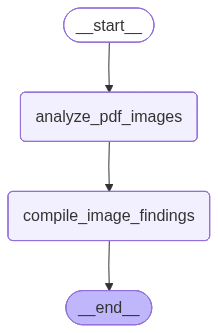

In [18]:
display(Image(visual_analysis_graph.get_graph().draw_mermaid_png()))

In [30]:
import json
from pydantic import TypeAdapter

In [52]:
with open("output/preprocessing_results/242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251019_204043/pdf_extraction/pdf_extraction_final_state_session_242fc6a46e4b36fcc00a3cfaabefe29a8cf8a5c9_20251019_204043.json", "r") as file:
    preprocessing_results = json.load(file)

In [53]:
from pdf_hunter.agents.pdf_extraction.schemas import PDFExtractionOutputState

In [54]:
adapter = TypeAdapter(PDFExtractionOutputState)
preprocessing_results = adapter.validate_python(preprocessing_results)

In [55]:
preprocessing_results.keys()

dict_keys(['output_directory', 'session_id', 'pdf_hash', 'page_count', 'pages_to_process', 'extracted_images', 'extracted_urls', 'errors'])

In [56]:
preprocessing_results['pages_to_process']

[0, 1, 2]

In [57]:
visual_analysis_input = {
    "extracted_images": preprocessing_results["extracted_images"],
    "extracted_urls": preprocessing_results["extracted_urls"],
    "number_of_pages_to_process": 3,
    "session_id": preprocessing_results.get("session_id"),
    "output_directory": "output",
}

In [ ]:
final_state = await visual_analysis_graph.ainvoke(visual_analysis_input)